<a href="https://colab.research.google.com/github/olgapoletkina/sf_data_science/blob/main/Home_work_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Задача

В приложенных файлах вы увидите данные по прохождению студентами тестов на образовательной платформе. Такие данные могут быть использованы для построения персонализированных ИИ-ассистентов для поддержки обучения студента. На текущем этапе сосредоточимся на начальном этапе — сборе и подготовке данных.

**Вам необходимо:**
Используя библиотеку pandas (или аналоги), проанализировать как можно больше характеристик, влияющих на успеваемость студентов.

## Описание данных

### test.csv

- **row_id**: (int64) ID code for the row.
- **timestamp**: (int64) The time in milliseconds between this user interaction and the first event completion from that user.
- **user_id**: (int32) ID code for the user.
- **content_id**: (int16) ID code for the user interaction.
- **content_type_id**: (int8)
  - 0 if the event was a question being posed to the user.
  - 1 if the event was the user watching a lecture.
- **task_container_id**: (int16) ID code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a `task_container_id`.
- **user_answer**: (int8) The user's answer to the question, if any. Read -1 as null, for lectures.
- **answered_correctly**: (int8) If the user responded correctly. Read -1 as null, for lectures.
- **prior_question_elapsed_time**: (float32) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. This value is null for a user's first question bundle or lecture.
  - Note that the time is the average time a user took to solve each question in the previous bundle.
- **prior_question_had_explanation**: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle and is null for a user's first question bundle or lecture. Typically, the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

### questions.csv

- **question_id**: Foreign key for the train/test `content_id` column, when the content type is question (0).
- **bundle_id**: Code for which questions are served together.
- **correct_answer**: The answer to the question. Can be compared with the `train` `user_answer` column to check if the user was right.
- **part**: The relevant section of the TOEIC test.
- **tags**: One or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.

### lectures.csv

- **lecture_id**: Foreign key for the train/test `content_id` column, when the content type is lecture (1).
- **part**: Top level category code for the lecture.
- **tag**: One tag code for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.
- **type_of**: Brief description of the core purpose of the lecture.


In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
!pip install phik

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import phik
from phik import resources
from phik.report import plot_correlation_matrix

import warnings
warnings.filterwarnings("ignore")

# Загрузка данных

In [63]:
try:
    lectures_df = pd.read_csv('/content/drive/MyDrive/MFTI/Python/Skillfactory/Home_work_3/lectures.csv')
    questions_df = pd.read_csv('/content/drive/MyDrive/MFTI/Python/Skillfactory/Home_work_3/questions.csv')
    # train_df = pd.read_csv('/content/drive/MyDrive/MFTI/Python/Skillfactory/Home_work_3/train.csv')
    train_df = pd.read_csv('/content/drive/MyDrive/MFTI/Python/Skillfactory/Home_work_3/train.csv', nrows=2000000) # использую часть df
except:
    lectures_df = pd.read_csv('data/lectures.csv')
    questions_df = pd.read_csv('data/questions.csv')
    # train_df = pd.read_csv('data/train.csv')
    train_df = pd.read_csv('data/train.csv', nrows=2000000)

## Изучение и предобработка данных.

Сделаем копии таблиц для дальнейшей работы и приобразований.

In [64]:
train = train_df.copy()
lectures = lectures_df.copy()
questions = questions_df.copy()

In [65]:
def df_summary(df):
    print("DataFrame Info:")
    print(df.info())
    print("\n" + "="*50 + "\n")

    print("First 5 rows of the DataFrame:")
    display(df.head())
    print("\n" + "="*50 + "\n")

    print("Sum of NaNs for each column:")
    print(df.isna().sum())
    print("\n" + "="*50 + "\n")

In [66]:
df_summary(lectures)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int64 
 3   type_of     418 non-null    object
dtypes: int64(3), object(1)
memory usage: 13.2+ KB
None


First 5 rows of the DataFrame:


,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question




Sum of NaNs for each column:
lecture_id    0
tag           0
part          0
type_of       0
dtype: int64




In [67]:
df_summary(questions)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
dtypes: int64(4), object(1)
memory usage: 528.4+ KB
None


First 5 rows of the DataFrame:


,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38




Sum of NaNs for each column:
question_id       0
bundle_id         0
correct_answer    0
part              0
tags              1
dtype: int64




In [68]:
df_summary(train)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int64  
 3   content_id                      int64  
 4   content_type_id                 int64  
 5   task_container_id               int64  
 6   user_answer                     int64  
 7   answered_correctly              int64  
 8   prior_question_elapsed_time     float64
 9   prior_question_had_explanation  object 
dtypes: float64(1), int64(8), object(1)
memory usage: 152.6+ MB
None


First 5 rows of the DataFrame:


,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,0,1,3,1,NaN,NaN
1,1,56943,115,5716,0,2,2,1,37000.0,False
2,2,118363,115,128,0,0,0,1,55000.0,False
3,3,131167,115,7860,0,3,0,1,19000.0,False
4,4,137965,115,7922,0,4,1,1,11000.0,False




Sum of NaNs for each column:
row_id                                0
timestamp                             0
user_id                               0
content_id                            0
content_type_id                       0
task_container_id                     0
user_answer                           0
answered_correctly                    0
prior_question_elapsed_time       46676
prior_question_had_explanation     7693
dtype: int64




В таблице `train` столбец `row_id` дублирует индекс, его можно удалить, `timestemp` и `prior_question_elapsed_time` переведем в минуты (для большей понятности)

In [69]:
train['timestamp_in_minutes'] = train['timestamp'] / 60000
train['prior_question_elapsed_time_in_minutes'] = train['prior_question_elapsed_time'] / 60000
train.drop(['row_id', 'timestamp', 'prior_question_elapsed_time'], axis=1, inplace=True)

In [70]:
train.head()

,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_had_explanation,timestamp_in_minutes,prior_question_elapsed_time_in_minutes
0,115,5692,0,1,3,1,NaN,0.000000,NaN
1,115,5716,0,2,2,1,False,0.949050,0.616667
2,115,128,0,0,0,1,False,1.972717,0.916667
3,115,7860,0,3,0,1,False,2.186117,0.316667
4,115,7922,0,4,1,1,False,2.299417,0.183333


## Уточнение задачи.

В задании сказано, что нам нужно проанализировать как можно больше характеристик, влияющих на успеваемость студентов. Покакзателем успеваемости в таблицах является столбец `answered_correctly` из таблицы `train`, соответственно мы будем изучать как эта переменная взаимосвязана с другими данными.

In [189]:
train['answered_correctly'].value_counts()

,count
answered_correctly,
1,1283458
0,677559
-1,38983


## Анализ характеристик, влияющих на успеваемость.

### Тип контента.

Посмотрим, как тип контента (вопрос или лекция) связан с правильными ответами студентов.

In [71]:
content_type_analysis = train.groupby('content_type_id')['answered_correctly'].mean()
print('Влияние типа контента на успеваемость:')
print(content_type_analysis)

Влияние типа контента на успеваемость:
content_type_id
0    0.654486
1   -1.000000
Name: answered_correctly, dtype: float64


`content_type_id = 0`: Это вопросы, на которые студенты отвечали. Средняя успеваемость по этим вопросам составляет `0.654`, что означает, что студенты в среднем отвечали правильно примерно на `65.4%` вопросов.

### Успеваемость и разделы теста.

Теперь используем таблицу `questions`, чтобы связать каждый вопрос из `train` с соответствующим `part` и посмотреть, как успеваемость студентов варьируется в зависимости от разделов теста.

Связь раздела теста связан с успеваемостью студентов:
part
1.0    0.718559
2.0    0.699579
3.0    0.682166
4.0    0.605860
5.0    0.597795
6.0    0.644218
7.0    0.650101
Name: answered_correctly, dtype: float64


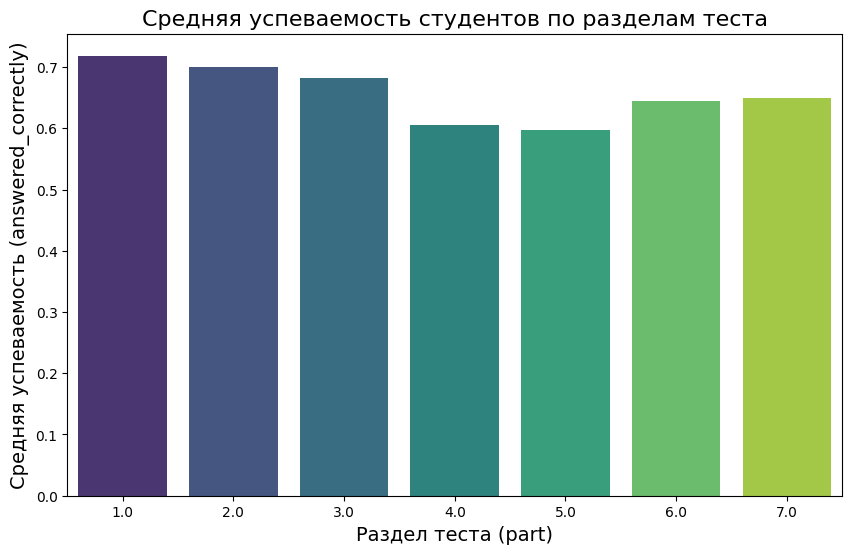

In [72]:
train_questions_merged = pd.merge(train, questions, left_on='content_id', right_on='question_id', how='left')

part_analysis = train_questions_merged.groupby('part')['answered_correctly'].mean()
print('Связь раздела теста связан с успеваемостью студентов:')
print(part_analysis)

palette_colors = sns.color_palette("viridis", len(part_analysis))

plt.figure(figsize=(10, 6))
sns.barplot(x=part_analysis.index, y=part_analysis.values, palette=palette_colors)

plt.title('Средняя успеваемость студентов по разделам теста', fontsize=14)
plt.xlabel('Раздел теста (part)', fontsize=14)
plt.ylabel('Средняя успеваемость (answered_correctly)', fontsize=14)

plt.show()

1. **Наибольшая успеваемость наблюдается в разделе 1** — средняя успеваемость составляет **72.2%**. Это может означать, что задания в этом разделе либо легче для студентов, либо они лучше подготовлены к этим вопросам.

2. **Наименьшая успеваемость в разделе 5** — средняя успеваемость составляет **59.9%**, что указывает на возможную сложность вопросов или недостаточную подготовку студентов к темам этого раздела.

3. **Разделы 2 и 3** также показывают относительно высокую успеваемость (**70.2%** и **68.6%** соответственно), что говорит о том, что студенты справляются с заданиями в этих разделах.

4. **Разделы 6 и 7** также находятся в среднем диапазоне по успеваемости (**65.5%** и **65.2%** соответственно), что говорит о средней сложности вопросов или уровне подготовки.

5. **Средняя успеваемость по всем разделам варьируется от **59.9%** до **72.2%**, что указывает на значительные различия в уровне сложности или понимания различных частей теста.

Эти данные могут быть полезны для выявления проблемных разделов теста, таких как раздел 5, и предоставления дополнительной поддержки студентам для повышения их успеваемости.


### Время затраченное на предыдущие вопросы и успеваемость.

Зассмотрим, как время, затраченное на предыдущие вопросы (через переменную `prior_question_elapsed_time_in_minutes`), влияет на успеваемость.

prior_question_elapsed_time_in_minutes
(-0.005, 0.5]    0.658777
(0.5, 1.0]       0.638040
(1.0, 1.5]       0.649818
(1.5, 2.0]       0.651822
(2.0, 2.5]       0.642337
(2.5, 3.0]       0.642821
(3.0, 3.5]       0.644904
(3.5, 4.0]       0.652235
(4.0, 4.5]       0.677570
(4.5, 5.0]       0.646781
Name: answered_correctly, dtype: float64


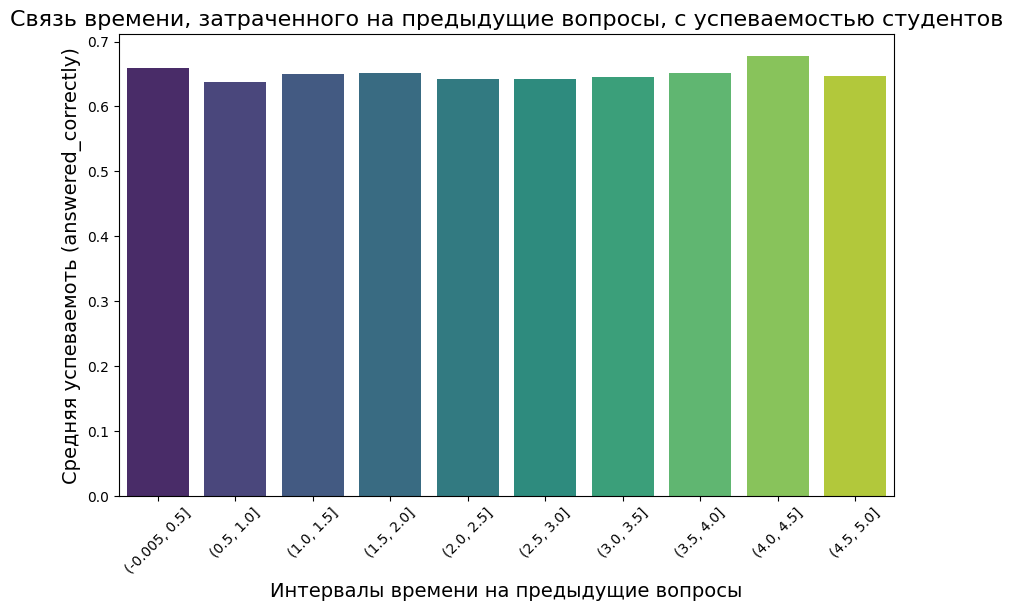

In [73]:
elapsed_time_analysis = train.groupby(pd.cut(train['prior_question_elapsed_time_in_minutes'], bins=10))['answered_correctly'].mean()
print(elapsed_time_analysis)

plt.figure(figsize=(10, 6))
sns.barplot(x=elapsed_time_analysis.index, y=elapsed_time_analysis.values, palette='viridis')

plt.title('Связь времени, затраченного на предыдущие вопросы, с успеваемостью студентов', fontsize=14)
plt.xlabel('Интервалы времени на предыдущие вопросы', fontsize=14)
plt.ylabel('Средняя успеваемоть (answered_correctly)', fontsize=14)

plt.xticks(rotation=45)
plt.show()

- **Время от 1.5 до 2 минут**: Показало одну из наивысших успеваемостей — около **65.2%**. Это указывает на то, что студенты, которые тратят это количество времени, более вероятно дадут правильные ответы.

- **Меньше 1 минуты**: Успеваемость составляет около **63.8%**, что немного ниже по сравнению с более длительным временем. Это может означать, что слишком быстрые ответы могут быть менее точными.

- **Время от 4 до 4.5 минут**: Показало наивысшую успеваемость — около **67.7%**, что может указывать на то, что более долгие размышления над вопросами иногда приводят к лучшим результатам.

- **Время более 3 минут**: В целом поддерживает успеваемость на уровне **64.4%**, что говорит о том, что студенты, которые тратят больше времени, также могут справляться с вопросами на приличном уровне.

В целом время, затраченное на предыдущие вопросы оказывает небольшую роль на изменение успеваемости студентов.

### Просмотр объяснений и успеваемость.

Посмотрим, как факт просмотра объяснений (переменная prior_question_had_explanation) влияет на успеваемость студентов.

prior_question_had_explanation
False    0.238696
True     0.670133
Name: answered_correctly, dtype: float64


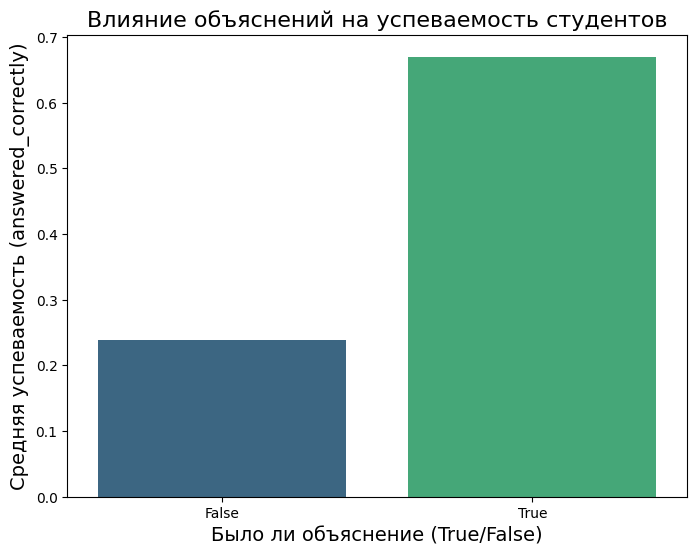

In [74]:
explanation_analysis = train.groupby('prior_question_had_explanation')['answered_correctly'].mean()
print(explanation_analysis)

plt.figure(figsize=(8, 6))
sns.barplot(x=explanation_analysis.index, y=explanation_analysis.values, palette='viridis')

plt.title('Влияние объяснений на успеваемость студентов', fontsize=14)
plt.xlabel('Было ли объяснение (True/False)', fontsize=14)
plt.ylabel('Средняя успеваемость (answered_correctly)', fontsize=14)

plt.show()

- **Когда объяснение не было показано (False)**: Средняя успеваемость составляет **23.87%**. Это довольно низкий результат, что может свидетельствовать о том, что отсутствие объяснений значительно снижает вероятность правильного ответа.

- **Когда объяснение было показано (True)**: Средняя успеваемость составляет **67.01%**. Это существенно выше, что указывает на то, что просмотр объяснений заметно улучшает результаты студентов.

Наличие объяснений играет важную роль в повышении успеваемости студентов. Те студенты, которые видели объяснения после ответов, чаще дают правильные ответы на вопросы.


### Опыт и успеваемость.

Изучим, как различные пользователи отвечают на вопросы и проанализируем влияние опыта или количества вопросов на их успеваемость.

,question,lecture,average_performance
user_id,,,
115,46,0,0.695652
124,30,0,0.233333
2746,19,1,0.500000
5382,125,3,0.632812
8623,109,3,0.598214


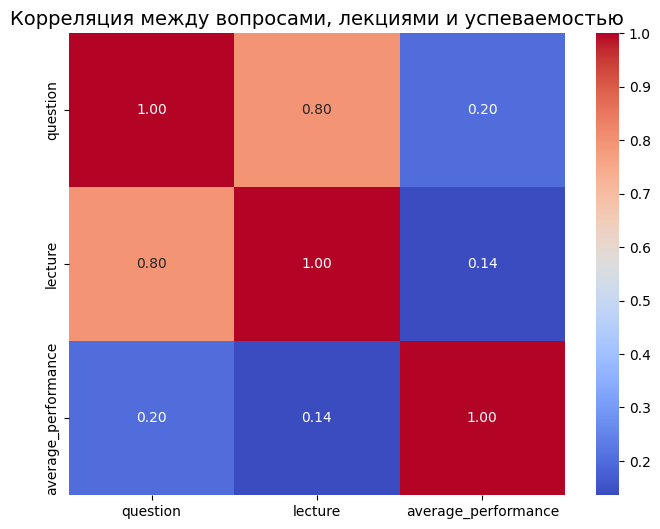

In [207]:
pivot_content_interactions = train.pivot_table(
    values='content_id',
    index='user_id',
    columns='content_type_id',
    aggfunc='count',
    fill_value=0
)

user_performance = train.groupby('user_id')['answered_correctly'].mean()
pivot_content_with_performance = pivot_content_interactions.join(user_performance, on='user_id')
# 0 if the event was a question being posed to the user.
# 1 if the event was the user watching a lecture.
pivot_content_with_performance.rename(columns={ 0: 'question',  1: 'lecture', 'answered_correctly': 'average_performance'}, inplace=True)
display(pivot_content_with_performance.head())

plt.figure(figsize=(8, 6))
correlation = pivot_content_with_performance[['question', 'lecture', 'average_performance']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')

plt.title('Корреляция между вопросами, лекциями и успеваемостью', fontsize=14)
plt.show()

- **Сильная положительная корреляция (0.80) между количеством вопросов и лекций**:
  Это означает, что пользователи, которые ответили на большее количество вопросов, также чаще просматривали лекции. Пользователи, активно взаимодействующие с вопросами, также взаимодействуют с лекциями.

- **Слабая положительная корреляция (0.20) между количеством вопросов и успеваемостью**:
  Количество вопросов, на которые ответил пользователь, лишь слабо связано с его успеваемостью. Это может указывать на то, что большое количество вопросов не всегда приводит к более высоким результатам.

- **Слабая положительная корреляция (0.14) между количеством лекций и успеваемостью**:
  Хотя лекции могут быть полезны, корреляция показывает, что количество просмотренных лекций также слабо связано с успеваемостью. Лекции помогают, но не являются основным фактором успеха.

Активное участие в вопросах и лекциях не всегда напрямую связано с высокой успеваемостью. Важны и другие факторы, такие как качество взаимодействий, тип заданий или наличие объяснений.


### Выявленеи сложности вопросов.

Проанализируем `task_container_id` на основе успеваемости для выявления наиболее сложных и легких наборов вопросов

- **task_container_id**: (int16) ID code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a `task_container_id`.

Отфильтруем `task_container_id` по вопросам и найдем самые сложные наборы.

In [76]:
task_container_performance = train[train['content_type_id'] == 0].groupby('task_container_id')['answered_correctly'].mean()
task_container_performance_sorted = pd.DataFrame(task_container_performance.sort_values())

print("Самые сложные task_container_id:")
display(task_container_performance_sorted[task_container_performance_sorted['answered_correctly'] == 0.0])

print("\nСамые легкие task_container_id:")
(task_container_performance_sorted[task_container_performance_sorted['answered_correctly'] == 1.0])

Самые сложные task_container_id:


,answered_correctly
task_container_id,
8155,0.0
8472,0.0
8745,0.0
8740,0.0
9170,0.0
9869,0.0
8668,0.0
8937,0.0
9684,0.0



Самые легкие task_container_id:


,answered_correctly
task_container_id,
9281,1.0
9389,1.0
9340,1.0
9464,1.0
9401,1.0
...,...
8866,1.0
7737,1.0
8864,1.0


- **Самые сложные наборы вопросов (task_container_id)**:
  Наборы, такие как **8155**, **8472**, **8745**, **8740**, и другие, имеют среднюю успеваемость **0%**, что говорит о том, что все студенты ответили неправильно на вопросы из этих наборов. Эти вопросы могут быть слишком сложными или требовать пересмотра.

- **Самые легкие наборы вопросов (task_container_id)**:
  Наборы, такие как **9281**, **9389**, **9340**, **9464**, и другие, имеют среднюю успеваемость **100%**, что означает, что все студенты ответили на них правильно. Эти наборы могут быть слишком легкими или хорошо поняты студентами.

Проанализируем `content_id` на основе успеваемости для выявления наиболее сложных и легких вопросов.

- **content_id**: (int16) ID code for the user interaction.

In [77]:
content_performance = train[train['content_type_id'] == 0].groupby('content_id')['answered_correctly'].mean()
content_performance_sorted = pd.DataFrame(content_performance.sort_values())

print("Самые сложные content_id:")
display(content_performance_sorted[content_performance_sorted['answered_correctly'] == 0.0])

print("\nСамые легкие content_id:")
content_performance_sorted[content_performance_sorted['answered_correctly'] == 1.0]

Самые сложные content_id:


,answered_correctly
content_id,
12685,0.0
12922,0.0
12914,0.0
13082,0.0
3316,0.0
...,...
13135,0.0
13147,0.0
12295,0.0



Самые легкие content_id:


,answered_correctly
content_id,
13098,1.0
5075,1.0
4879,1.0
4632,1.0
850,1.0
...,...
12776,1.0
12777,1.0
12778,1.0


- **Самые сложные вопросы (content_id)**:
  Всего **88** вопросов, имеют среднюю успеваемость **0%**, что указывает на то, что ни один студент не дал правильного ответа. Эти вопросы могут быть слишком сложными или плохо поняты.

- **Самые легкие вопросы (content_id)**:
  **767** вопросов, имеют среднюю успеваемость **100%**, что означает, что все студенты ответили правильно. Эти вопросы могут быть слишком простыми или хорошо известны студентам.

Теперь с помощью объединения таблиц посмотрим успеваемость по разделам `TOEIC`

- **question_id**: Foreign key for the train/test `content_id` column, when the content type is question (0).
- **part**: The relevant section of the TOEIC test.

Средняя успеваемость по разделам TOEIC:


,answered_correctly
part,
1,0.718559
2,0.699579
3,0.682166
7,0.650101
6,0.644218
4,0.605860
5,0.597795


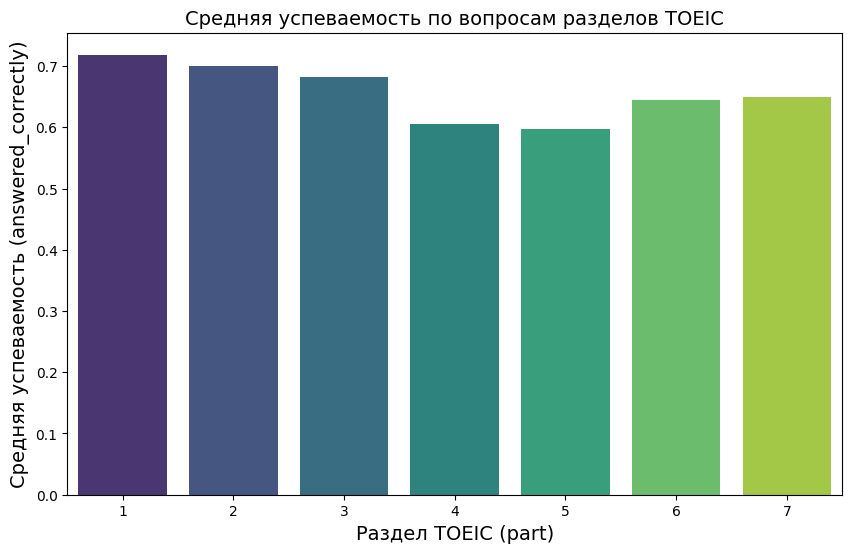

In [124]:
merged_train_questions = pd.merge(train, questions, left_on='content_id', right_on='question_id', how='inner')
merged_train_questions.head()

toeic_performance = merged_train_questions.groupby('part')['answered_correctly'].mean()
toeic_performance.sort_values(ascending=False, inplace=True)

print("Средняя успеваемость по разделам TOEIC:")
display(toeic_performance)

plt.figure(figsize=(10, 6))
sns.barplot(x=toeic_performance.index, y=toeic_performance.values, palette='viridis')

plt.title('Средняя успеваемость по вопросам разделов TOEIC', fontsize=14)
plt.xlabel('Раздел TOEIC (part)', fontsize=14)
plt.ylabel('Средняя успеваемость (answered_correctly)', fontsize=14)

plt.xticks(rotation=0)
plt.show()

1. **Раздел 1**: Средняя успеваемость составляет **71.86%**, что указывает на то, что этот раздел является наиболее успешным для студентов. Возможно, задания в этом разделе либо легче, либо студенты лучше подготовлены к этим вопросам.

2. **Раздел 2**: Средняя успеваемость **69.96%**, что также говорит о достаточно хорошем уровне понимания вопросов данного раздела.

3. **Раздел 3**: Средняя успеваемость **68.22%**, что указывает на стабильные результаты в этом разделе.

4. **Разделы 7, 6 и 4**: Успеваемость варьируется от **60.59%** до **65.01%**, что говорит о средней сложности вопросов. Студенты демонстрируют умеренные результаты в этих разделах.

5. **Раздел 5**: Показал самую низкую среднюю успеваемость — **59.78%**. Этот раздел может содержать более сложные задания или тематику, с которой студенты испытывают затруднения.

Студенты лучше всего справляются с вопросами из разделов 1 и 2, тогда как раздел 5 является наиболее сложным. Это может помочь при корректировке учебного процесса или предоставлении дополнительной поддержки по сложным темам.

### Phik корреляция

interval columns not set, guessing: ['user_id', 'content_id', 'content_type_id', 'task_container_id', 'user_answer', 'answered_correctly', 'timestamp_in_minutes', 'prior_question_elapsed_time_in_minutes', 'question_id', 'bundle_id', 'correct_answer', 'part']


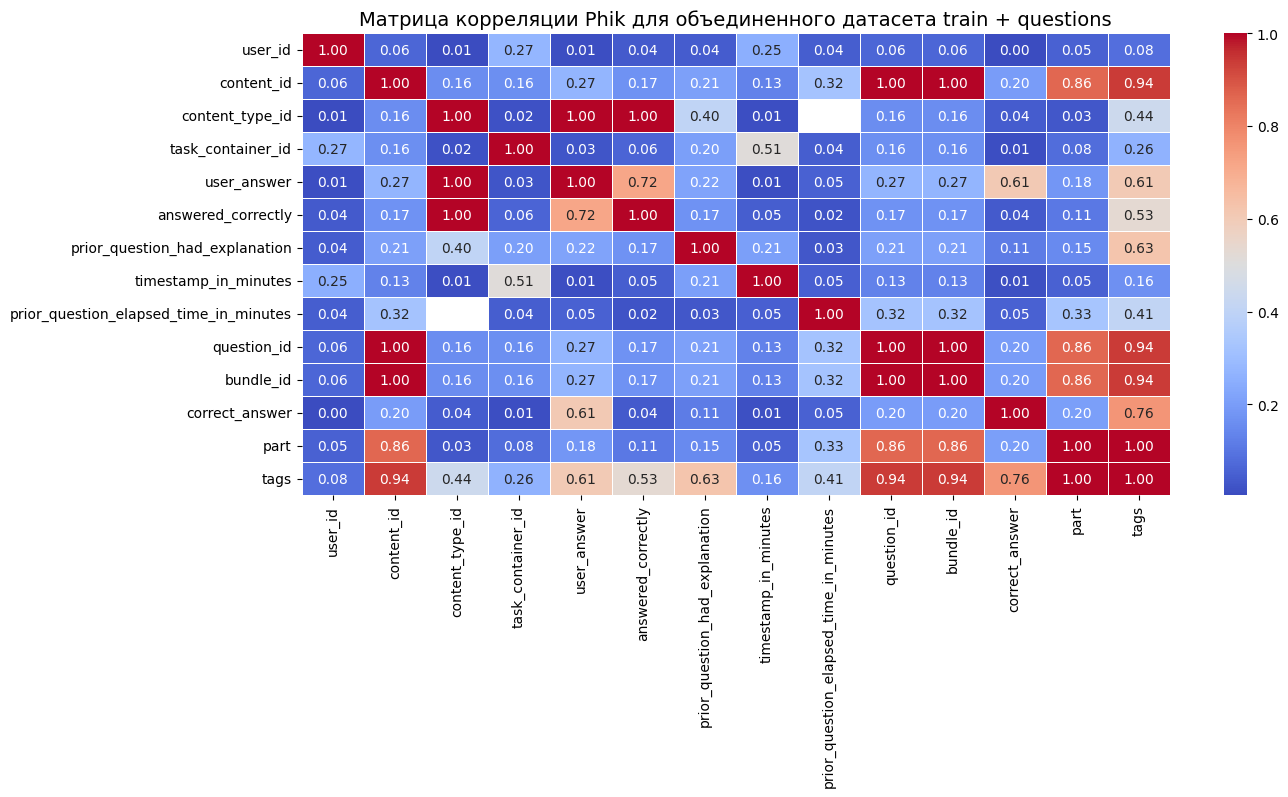

In [125]:
phik_matrix = merged_train_questions.phik_matrix()

plt.figure(figsize=(14, 6))
sns.heatmap(phik_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Матрица корреляции Phik для объединенного датасета train + questions', fontsize=14)
plt.show()

- **`correct_answer` и `tags` (0.76)**: Относительно сильная корреляция с тегами вопросов. Это может указывать на то, что определённые типы вопросов (обозначенные тегами) имеют более предсказуемые или вероятные правильные ответы.

Корреляция между правильными ответами (`correct_answer`) и другими признаками в целом невысокая, что может говорить о том, что правильный ответ не сильно зависит от таких факторов, как время на вопросы или группы вопросов. Однако существуют умеренные зависимости с тегами вопросов и разделами TOEIC, что указывает на возможное влияние типа вопросов на вероятность правильного ответа.

## Объединение всех таблиц в одну.

Объединим все датасеты в один, оставив все строки в `train`.

In [157]:
merged_df = pd.merge(train, questions, left_on='content_id', right_on='question_id', how='left')
merged_df = pd.merge(merged_df, lectures, left_on='content_id', right_on='lecture_id', how='left')
merged_df.drop(['question_id', 'lecture_id'], axis=1, inplace=True)
merged_df.rename(columns={'part_x': 'TOEIC_section', 'part_y': 'lecture_category_code'}, inplace=True)

print(merged_df.info())
merged_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 16 columns):
 #   Column                                  Dtype  
---  ------                                  -----  
 0   user_id                                 int64  
 1   content_id                              int64  
 2   content_type_id                         int64  
 3   task_container_id                       int64  
 4   user_answer                             int64  
 5   answered_correctly                      int64  
 6   prior_question_had_explanation          object 
 7   timestamp_in_minutes                    float64
 8   prior_question_elapsed_time_in_minutes  float64
 9   bundle_id                               float64
 10  correct_answer                          float64
 11  TOEIC_section                           float64
 12  tags                                    object 
 13  tag                                     float64
 14  lecture_category_code             

,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_had_explanation,timestamp_in_minutes,prior_question_elapsed_time_in_minutes,bundle_id,correct_answer,TOEIC_section,tags,tag,lecture_category_code,type_of
0,115,5692,0,1,3,1,NaN,0.000000,NaN,5692.0,3.0,5.0,151,NaN,NaN,NaN
1,115,5716,0,2,2,1,False,0.949050,0.616667,5716.0,2.0,5.0,168,NaN,NaN,NaN
2,115,128,0,0,0,1,False,1.972717,0.916667,128.0,0.0,1.0,131 149 92,NaN,NaN,NaN
3,115,7860,0,3,0,1,False,2.186117,0.316667,7860.0,0.0,1.0,131 104 81,NaN,NaN,NaN
4,115,7922,0,4,1,1,False,2.299417,0.183333,7922.0,1.0,1.0,131 149 92,NaN,NaN,NaN


### Ответы пользователей vs правильные ответы

Посмотрим по объединенной таблице на правильные ответы на вопросы и ответы пользователей.

In [158]:
merged_df['user_correct'] = (merged_df['user_answer'] == merged_df['correct_answer']).astype(int)

display(merged_df[['user_answer', 'correct_answer', 'user_correct']].head())

correct_count = merged_df['user_correct'].sum()
total_answers = merged_df['user_correct'].count()
accuracy = correct_count / total_answers

print(f"Общее количество ответов: {total_answers}")
print(f"Количество правильных ответов: {correct_count}")
print(f"Точность (процент правильных ответов): {accuracy:.2%}")

,user_answer,correct_answer,user_correct
0,3,3.0,1
1,2,2.0,1
2,0,0.0,1
3,0,0.0,1
4,1,1.0,1


Общее количество ответов: 2000000
Количество правильных ответов: 1283458
Точность (процент правильных ответов): 64.17%


### Успеваемость и наличие разъяснений в соответствии разделам TOEIC test


Создадим сводную таблицу для анализа зависимости успеваемости и соответствующими разделами `TOEIC test`.

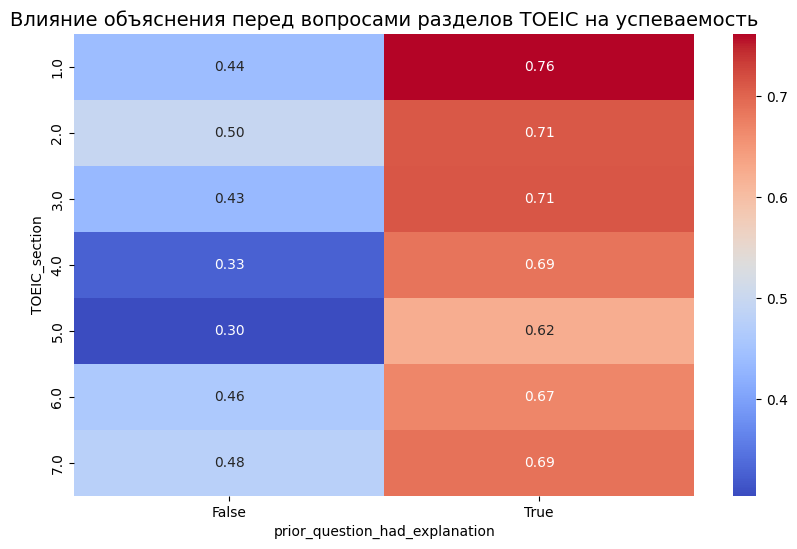

In [159]:
pivot_table = merged_df.pivot_table(
    values='answered_correctly',
    index='TOEIC_section',
    columns='prior_question_had_explanation',
    aggfunc='mean',
    fill_value=0
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Влияние объяснения перед вопросами разделов TOEIC на успеваемость', fontsize=14)
plt.show()

 - **Высокая успеваемость при наличии объяснений**: При наличии объяснений (столбец `True`), успеваемость значительно выше во всех разделах TOEIC. Например, в разделе 1 она достигает **76%**, что является наивысшим показателем.

- **Низкая успеваемость без объяснений**: Без объяснений (столбец `False`), успеваемость значительно ниже. В некоторых разделах, таких как раздел 5, она падает до **30%**.

- **Разделы 4 и 5** показывают самые низкие результаты, как с объяснением, так и без него, что может указывать на их сложность для студентов.

Наличие объяснений заметно улучшает результаты студентов во всех разделах TOEIC, особенно в разделах 1, 2 и 3, где разница между успеваемостью с объяснениями и без них наибольшая.


### Phik для объединенной таблицы

interval columns not set, guessing: ['user_id', 'content_id', 'content_type_id', 'task_container_id', 'user_answer', 'answered_correctly', 'timestamp_in_minutes', 'prior_question_elapsed_time_in_minutes', 'bundle_id', 'correct_answer', 'TOEIC_section', 'tag', 'lecture_category_code', 'user_correct']


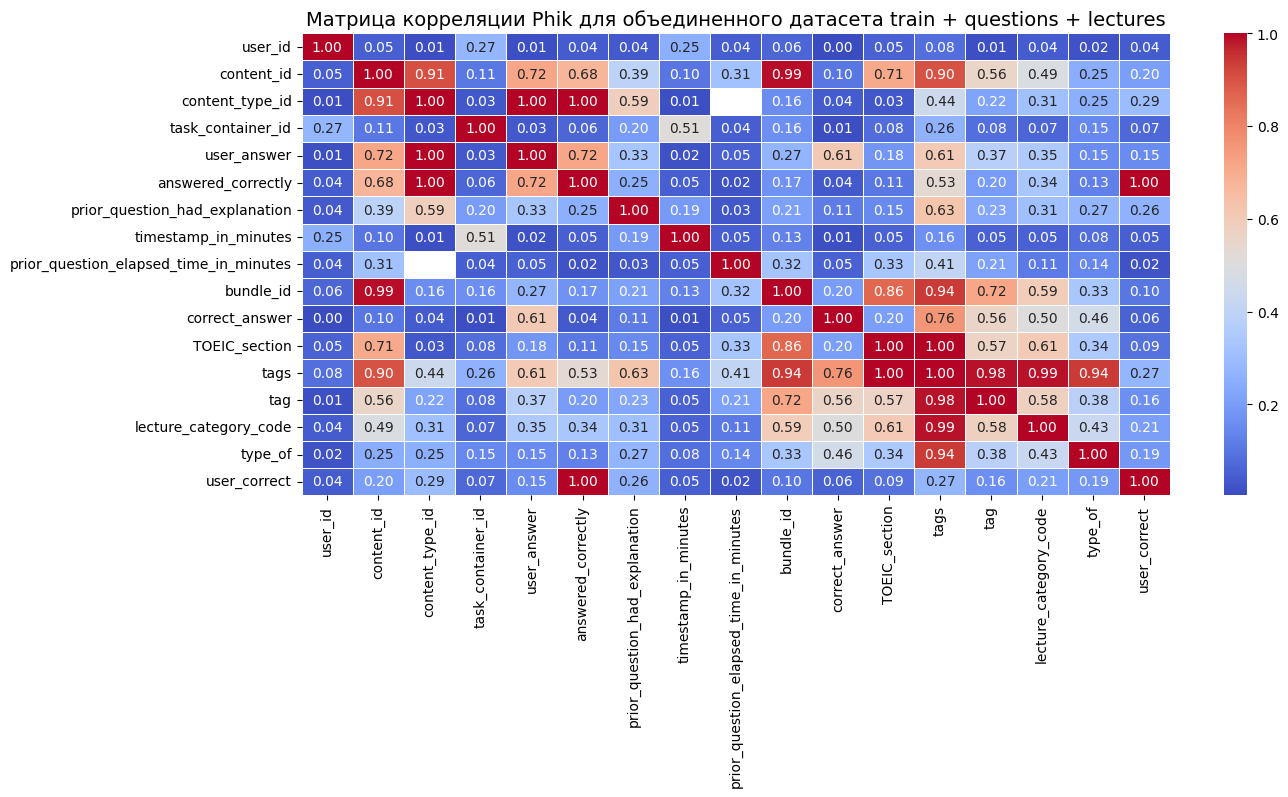

In [163]:
phik_matrix_merged = merged_df.phik_matrix()

plt.figure(figsize=(14, 6))
sns.heatmap(phik_matrix_merged, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Матрица корреляции Phik для объединенного датасета train + questions + lectures', fontsize=14)
plt.show()

**`tag`** из лекций и **`tags`** из вопросов вероятно описывают схожие или совпадающие темы, что объясняет высокую корреляцию. Лекции и вопросы могут быть связаны общей тематикой, либо теги организованы по одинаковым категориям, что делает их связанными. Попробуем разобраться какие таги являются самыми сложными для судентов при ответе на вопросы и лекции с какими тагами они просматривают больше всего.

Работа с `tag`  и `tags`

In [164]:
question_tags_performance = merged_df[merged_df['content_type_id'] == 0].groupby('tags')['answered_correctly'].mean()
question_tags_performance_sorted = question_tags_performance.sort_values()

print("Самые сложные теги для вопросов:")
display(question_tags_performance_sorted.head())

lecture_tags_popularity = merged_df[merged_df['content_type_id'] == 1].groupby('tag')['user_id'].count()
lecture_tags_popularity_sorted = lecture_tags_popularity.sort_values(ascending=False)

print("\nСамые популярные теги для лекций:")
display(lecture_tags_popularity_sorted.head())

Самые сложные теги для вопросов:


,answered_correctly
tags,
84 97 16 135 162,0.000000
84 76 16 135 162,0.000000
113 38 3,0.076923
118 42 21 162,0.118343
106 67 162 92,0.168582



Самые популярные теги для лекций:


,user_id
tag,
62.0,1119
27.0,1109
136.0,800
163.0,795
26.0,776


В коде сверху были отфильтрованы строки с самыми популярными темами лекций и сложными темами вопросов.

В дальнейшем можно сопоставить теги по сложности вопроссов и популярности лекций если подтвердится предположение, что они совпадают, то есть значения тэгов в таблице `lectures` и таблице `questions` относятся к одним и тем же темам.

## Заключение

В ходе анализа данных об успеваемости студентов был проведен детальный разбор различных факторов, которые могут оказывать влияние на их результаты. Рассмотрим основные выводы:

1. **Тип контента и успеваемость**:
   - Средняя успеваемость студентов на вопросы составляет **65.4%**.

2. **Разделы теста TOEIC и успеваемость**:
   - Успеваемость студентов варьируется в зависимости от разделов теста. Наибольший успех наблюдается в разделе 1 (**72.2%**), в то время как раздел 5 является самым сложным с результатом **59.9%**. Это может указывать на различия в сложности вопросов или подготовке студентов к этим разделам.

3. **Влияние времени на вопросы**:
   - Время, затраченное на предыдущие вопросы, оказывает минимальное влияние на результаты.

4. **Роль объяснений**:
   - Наличие объяснений существенно влияет на успеваемость. Студенты, которые видели объяснение, в среднем отвечали правильно на **67.01%** вопросов, тогда как те, кто не видел объяснений, показали результат всего **23.87%**. Объяснения играют важную роль в обучении студентов.

5. **Взаимосвязь лекций и вопросов**:
   - Обнаружена слабая положительная корреляция между количеством просмотренных лекций и успеваемостью студентов (**0.14**). То же самое относится к количеству отвеченных вопросов и успеваемости (**0.20**). Это свидетельствует о том, что хотя активное участие в вопросах и лекциях способствует успеху, оно не является определяющим фактором.

6. **Анализ сложности вопросов и наборов**:
   - Некоторые наборы вопросов (task_container_id) и отдельные вопросы (content_id) показали нулевую или 100% успеваемость среди студентов, что может свидетельствовать либо о слишком высокой сложности, либо о слишком низкой.

7. **Phik-корреляция и анализ тегов**:
   - Применение Phik-корреляции показало интересные связи между тегами лекций и вопросов. Высокая корреляция между тегами вопросов и правильными ответами (**0.76**) указывает на важную роль, которую теги играют в успешности студентов. Это может быть полезно для дальнейшего анализа популярных и сложных тем.

8. **Популярные лекции и сложные вопросы**:
   - Анализ тегов выявил популярные темы лекций и сложные вопросы. В дальнейшем можно исследовать, совпадают ли сложные теги вопросов с популярными тегами лекций, чтобы адаптировать учебный процесс.

### Заключительный вывод:
Активность студентов в вопросах и лекциях, наличие объяснений, время на ответы и различные разделы теста — все эти факторы оказывают влияние на успеваемость. Основные проблемы выявлены в разделе 5, где студенты показывают худшие результаты, что требует дополнительного внимания. Теги лекций и вопросов могут быть использованы для дальнейшего анализа с целью выявления самых сложных тем для студентов, что сможет в дальнейшем положительно повлиять на контент.
